## A6 - 6.5 - v1 Unsupervised Machine Learning

### This script contains the following:

#### 1.1. Importing libraries and data
#### 1.2. Creating a new dataset wtih suitable columns with extracted and converted data
#### 2. The elbow technique
#### 3. k-means clustering

### 1.1 Importing libraries and data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans # Here is where you import the k-means algorithm from scikit-learn.
import pylab as pl # PyLab is a convenience module that bulk imports matplotlib.

In [3]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [4]:
# Defining the path

path = r'C:\Users\psalo\OneDrive\Study\CF - DA Immersion\A6 - Advanced Analytics & Dashboard Design\A6 - Wellness Supplement Sales Analysis'

In [5]:
#Importing the dataset

df = pd.read_csv(os.path.join(path, 'Data', 'Supplement_Sales_Weekly_v2.csv'))

In [6]:
df.shape

(4384, 10)

In [7]:
df.head()

,date,product,category,unit_sold,price,revenue,discount,unit_returned,location,platform
0,1/6/2020,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
1,1/6/2020,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon
2,1/6/2020,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon
3,1/6/2020,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart
4,1/6/2020,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4384 entries, 0 to 4383
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4384 non-null   object 
 1   product        4384 non-null   object 
 2   category       4384 non-null   object 
 3   unit_sold      4384 non-null   int64  
 4   price          4384 non-null   float64
 5   revenue        4384 non-null   float64
 6   discount       4384 non-null   float64
 7   unit_returned  4384 non-null   int64  
 8   location       4384 non-null   object 
 9   platform       4384 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 342.6+ KB


### 1.2 Making the changes to dataset to ensure that it is suitable for the elbow technique

#### Adding two new derived columns with calculated fields

In [9]:
# New derived column - return_rate (also avoiding division by zero)

df['return_rate'] = df['unit_returned'] / df['unit_sold'].replace(0, np.nan)


In [10]:
# New derived column - actual_price (the discount is % rate and the price is post-discount)

# Calculating actual price before discount
df['actual_price'] = df['price'] / (1 - df['discount'] / 100)

# Rounging for clarity
df['actual_price'] = df['actual_price'].round(2)

In [11]:
# Checking on two new columns

df.head()

,date,product,category,unit_sold,price,revenue,discount,unit_returned,location,platform,return_rate,actual_price
0,1/6/2020,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart,0.013986,31.99
1,1/6/2020,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon,0.000000,42.53
2,1/6/2020,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon,0.000000,12.94
3,1/6/2020,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart,0.000000,16.08
4,1/6/2020,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb,0.019108,35.56


#### Creating prod_id and cat_id (will help with elbow technique)

In [13]:
# 1 - Extracting unique product-category pairs

df_prod = df[['product', 'category']].drop_duplicates().reset_index(drop=True)

In [14]:
# 2 - Generating unique prod_id

df_prod['prod_id'] = range(1, len(df_prod) + 1)

In [15]:
# 3 - Creating a category lookup table

df_cat = df_prod[['category']].drop_duplicates().reset_index(drop=True)
df_cat['cat_id'] = range(1, len(df_cat) + 1)

In [16]:
# 4 - Merging cat_id into df_prod

df_prod = df_prod.merge(df_cat, on='category', how='left')

In [17]:
df_prod

,product,category,prod_id,cat_id
0,Whey Protein,Protein,1,1
1,Vitamin C,Vitamin,2,2
2,Fish Oil,Omega,3,3
3,Multivitamin,Vitamin,4,2
4,Pre-Workout,Performance,5,4
5,BCAA,Amino Acid,6,5
6,Creatine,Performance,7,4
7,Zinc,Mineral,8,6
8,Collagen Peptides,Protein,9,1
9,Magnesium,Mineral,10,6


#### Creating df_loc with location info

In [18]:
# 1 - Extracting unique location names

df_loc = df[['location']].drop_duplicates().reset_index(drop=True)

In [19]:
# 2 - Generating unique loc_id for each location

df_loc['loc_id'] = range(1, len(df_loc) + 1)

In [20]:
df_loc

,location,loc_id
0,Canada,1
1,UK,2
2,USA,3


#### Creating df_platform with platform info

In [21]:
# 1 - Extracting unique platform names

df_platform = df[['platform']].drop_duplicates().reset_index(drop=True)

In [23]:
# 2 - Generating unique platform_id for each platform

df_platform['platform_id'] = range(1, len(df_loc) + 1)

In [24]:
df_platform

,platform,platform_id
0,Walmart,1
1,Amazon,2
2,iHerb,3


#### Extract Month and Year from the Date columns and save this info in two new columns

In [25]:
# Ensure the date column is in datetime format

df['date'] = pd.to_datetime(df['date'])


In [26]:
# Extract month and year into new columns

df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year


In [27]:
df

,date,product,category,unit_sold,price,revenue,discount,unit_returned,location,platform,return_rate,actual_price,month,year
0,2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart,0.013986,31.99,1,2020
1,2020-01-06,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon,0.000000,42.53,1,2020
2,2020-01-06,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon,0.000000,12.94,1,2020
3,2020-01-06,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart,0.000000,16.08,1,2020
4,2020-01-06,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb,0.019108,35.56,1,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4379,2025-03-31,Melatonin,Sleep Aid,160,47.79,7646.40,0.21,1,USA,iHerb,0.006250,47.89,3,2025
4380,2025-03-31,Biotin,Vitamin,154,38.12,5870.48,0.22,1,UK,Walmart,0.006494,38.20,3,2025
4381,2025-03-31,Green Tea Extract,Fat Burner,139,20.40,2835.60,0.12,3,USA,iHerb,0.021583,20.42,3,2025
4382,2025-03-31,Iron Supplement,Mineral,154,18.31,2819.74,0.23,2,Canada,Amazon,0.012987,18.35,3,2025


#### Creating a copy of the dataset called df_elbow

In [41]:
# Creating a copy of the dataset so that we can use the copy of this database to make all columns numericalit can then be used for the elbow technique.

df_elbow = df.copy()


In [42]:
df_elbow

,date,product,category,unit_sold,price,revenue,discount,unit_returned,location,platform,return_rate,actual_price,month,year
0,2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart,0.013986,31.99,1,2020
1,2020-01-06,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon,0.000000,42.53,1,2020
2,2020-01-06,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon,0.000000,12.94,1,2020
3,2020-01-06,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart,0.000000,16.08,1,2020
4,2020-01-06,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb,0.019108,35.56,1,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4379,2025-03-31,Melatonin,Sleep Aid,160,47.79,7646.40,0.21,1,USA,iHerb,0.006250,47.89,3,2025
4380,2025-03-31,Biotin,Vitamin,154,38.12,5870.48,0.22,1,UK,Walmart,0.006494,38.20,3,2025
4381,2025-03-31,Green Tea Extract,Fat Burner,139,20.40,2835.60,0.12,3,USA,iHerb,0.021583,20.42,3,2025
4382,2025-03-31,Iron Supplement,Mineral,154,18.31,2819.74,0.23,2,Canada,Amazon,0.012987,18.35,3,2025


#### Updating df_elbow with all numerical id for product, category, location and platform

In [43]:
# 1 -  Join df_prod on product and category
df_elbow = df_elbow.merge(df_prod[['product', 'category', 'prod_id', 'cat_id']],
                        on=['product', 'category'],
                        how='inner')

# 2 - Join df_loc on location
df_elbow = df_elbow.merge(df_loc[['location', 'loc_id']],
                        on='location',
                        how='inner')

# 3 - Join df_platform on platform
df_elbow = df_elbow.merge(df_platform[['platform', 'platform_id']],
                        on='platform',
                        how='inner')

In [44]:
df_elbow.head()

,date,product,category,unit_sold,price,revenue,discount,unit_returned,location,platform,return_rate,actual_price,month,year,prod_id,cat_id,loc_id,platform_id
0,2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart,0.013986,31.99,1,2020,1,1,1,1
1,2020-01-06,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon,0.000000,42.53,1,2020,2,2,2,2
2,2020-01-06,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon,0.000000,12.94,1,2020,3,3,1,2
3,2020-01-06,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart,0.000000,16.08,1,2020,4,2,1,1
4,2020-01-06,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb,0.019108,35.56,1,2020,5,4,1,3


In [48]:
# Dropping all unnecessary columns before applying elbow technique

df_elbow.drop(columns=['date','product','category','location','platform'], inplace=True)


KeyError: "['date', 'product', 'category', 'location', 'platform'] not found in axis"

In [47]:
df_elbow.head()

,unit_sold,price,revenue,discount,unit_returned,return_rate,actual_price,month,year,prod_id,cat_id,loc_id,platform_id
0,143,31.98,4573.14,0.03,2,0.013986,31.99,1,2020,1,1,1,1
1,139,42.51,5908.89,0.04,0,0.000000,42.53,1,2020,2,2,2,2
2,161,12.91,2078.51,0.25,0,0.000000,12.94,1,2020,3,3,1,2
3,140,16.07,2249.80,0.08,0,0.000000,16.08,1,2020,4,2,1,1
4,157,35.47,5568.79,0.25,3,0.019108,35.56,1,2020,5,4,1,3


### 2. The elbow technique

In [49]:
num_cl = range(1, 10) # Defines the range of potential clusters in the data.
kmeans = [KMeans(n_clusters=i) for i in num_cl] # Defines k-means clusters in the range assigned above.

In [50]:
score = [kmeans[i].fit(df_elbow).score(df_elbow) for i in range(len(kmeans))] # Creates a score that represents 
# a rate of variation for the given cluster option.

score

[-21071818389.558826,
 -5801386277.021734,
 -2605176171.032914,
 -1506165518.104239,
 -1002237558.6130148,
 -710199052.1053171,
 -528809539.6752407,
 -425802065.457085,
 -320434372.2449409]

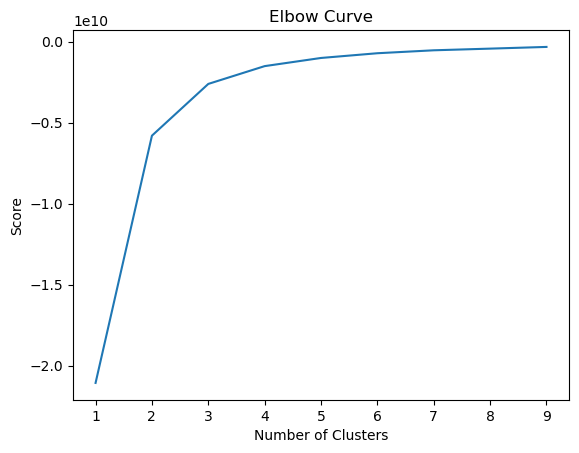

In [75]:
# Plot the elbow curve using Pylab
pl.plot(num_cl, score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')

# Save to your specified path
pl.savefig(r'C:\Users\psalo\OneDrive\Study\CF - DA Immersion\A6 - Advanced Analytics & Dashboard Design\A6 - Wellness Supplement Sales Analysis\Visualizations\elbow_curve.png',
           dpi=300, bbox_inches='tight')

pl.show()


#####  Sharpest drop is from k=1 to k=3. It indicates that clustering significantly improves compactness up to 3 clusters.

### 3. k-means clustering

In [52]:
# Create the k-means object.

kmeans = KMeans(n_clusters = 3) 


In [56]:
# Fit the k-means object to the data.

kmeans.fit(df_elbow)

KMeans(n_clusters=3)

In [57]:
df_elbow['clusters'] = kmeans.fit_predict(df_elbow)

In [58]:
df_elbow.head()

,unit_sold,price,revenue,discount,unit_returned,return_rate,actual_price,month,year,prod_id,cat_id,loc_id,platform_id,clusters
0,143,31.98,4573.14,0.03,2,0.013986,31.99,1,2020,1,1,1,1,0
1,139,42.51,5908.89,0.04,0,0.000000,42.53,1,2020,2,2,2,2,0
2,161,12.91,2078.51,0.25,0,0.000000,12.94,1,2020,3,3,1,2,2
3,140,16.07,2249.80,0.08,0,0.000000,16.08,1,2020,4,2,1,1,2
4,157,35.47,5568.79,0.25,3,0.019108,35.56,1,2020,5,4,1,3,0


In [59]:
df_elbow['clusters'].value_counts()

clusters
0    1617
2    1464
1    1303
Name: count, dtype: int64

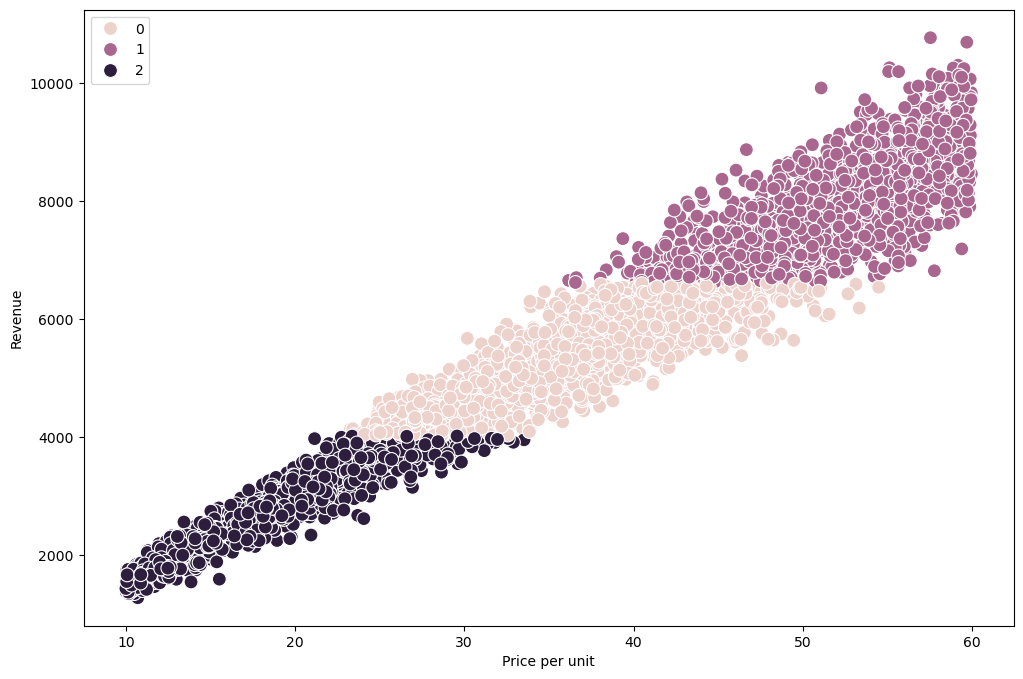

In [60]:
# Plot the clusters for the "revenue" and "price" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_elbow['price'], y=df_elbow['revenue'], hue=kmeans.labels_, s=100) 
# Here, you're subsetting `X` for the x and y arguments to avoid using their labels. 
# `hue` takes the value of the attribute `kmeans.labels_`, which is the result of running the k-means algorithm.
# `s` represents the size of the points you want to see in the plot.

ax.grid(False) # This removes the grid from the background.
plt.xlabel('Price per unit') # Label x-axis.
plt.ylabel('Revenue') # Label y-axis.
plt.show()

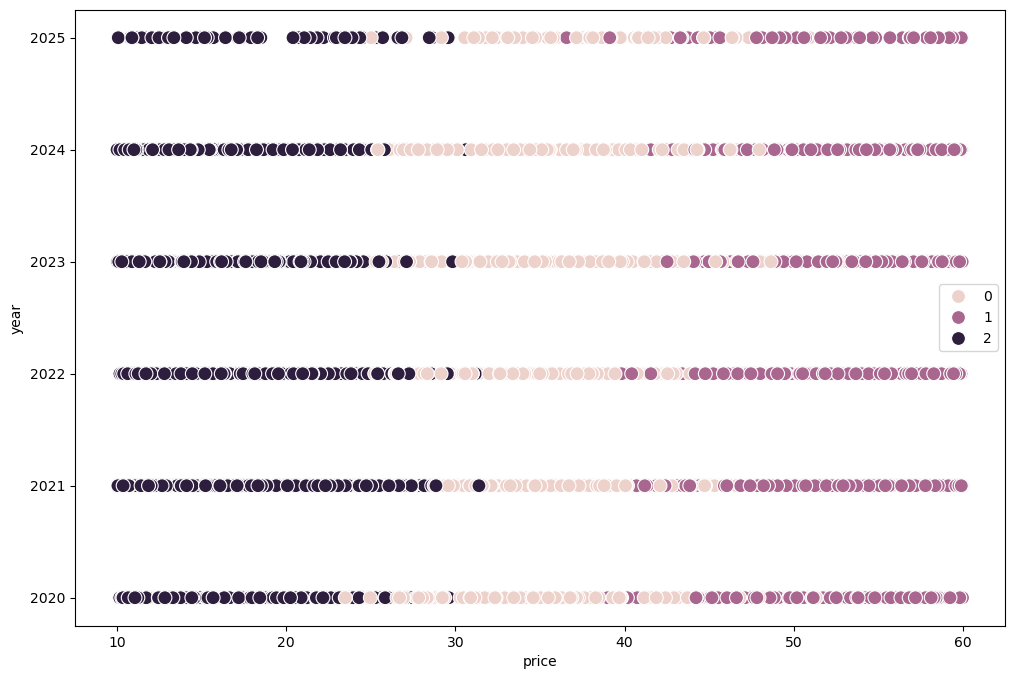

In [65]:
# Plot the clusters for the "year" and "price" variables.

plt.figure(figsize=(12,8))
ax = sns.scatterplot(x=df_elbow['price'], y=df_elbow['year'], hue=kmeans.labels_, s=100)

ax.grid(False) 
plt.xlabel('price') 
plt.ylabel('year') 
plt.show()

In [68]:
df_elbow.loc[df_elbow['clusters'] == 2, 'cluster'] = 'dark purple'
df_elbow.loc[df_elbow['clusters'] == 1, 'cluster'] = 'purple'
df_elbow.loc[df_elbow['clusters'] == 0, 'cluster'] = 'pink'

In [69]:
df_elbow.groupby('cluster').agg({'price':['mean', 'median'], 
                         'revenue':['mean', 'median'], 
                         'unit_sold':['mean', 'median'],
                          'unit_returned':['mean', 'median']})

price             revenue             unit_sold         \
                  mean median         mean    median        mean median   
cluster                                                                   
dark purple  18.639816  18.44  2743.296749  2742.065  148.146175  148.0   
pink         35.824910  35.54  5307.466543  5293.950  149.221398  149.0   
purple       51.621903  51.98  7916.285963  7814.400  153.722947  153.0   

            unit_returned         
                     mean median  
cluster                           
dark purple      1.541667    1.0  
pink             1.491651    1.0  
purple           1.569455    1.0

### 4. Saving the datasets in Data folder

In [70]:
df_elbow.to_csv('C:\\Users\\psalo\\OneDrive\\Study\\CF - DA Immersion\\A6 - Advanced Analytics & Dashboard Design\\A6 - Wellness Supplement Sales Analysis\\Data\\Supplementsales_clustering.csv', index=False)

In [71]:
df.to_csv('C:\\Users\\psalo\\OneDrive\\Study\\CF - DA Immersion\\A6 - Advanced Analytics & Dashboard Design\\A6 - Wellness Supplement Sales Analysis\\Data\\Supplement_Sales_Weekly_v3.csv', index=False)